# **Import Required Libraries**

In [ ]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# Model Saving
import joblib

# **Upload Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving predictive_maintenance_dataset.csv to predictive_maintenance_dataset (1).csv


# **Load Dataset into DataFrame**

In [ ]:
df = pd.read_csv("predictive_maintenance_dataset.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# **Drop Irrelevant Columns (Data Cleaning)**

In [ ]:
df = df.drop(columns=[
    'UDI',
    'Product ID',
    'TWF',
    'HDF',
    'PWF',
    'OSF',
    'RNF'
])

# **Explore Dataset Shape and Class Distribution (EDA)**

Shape: (10000, 7)

Class Distribution:
 Machine failure
0    9661
1     339
Name: count, dtype: int64


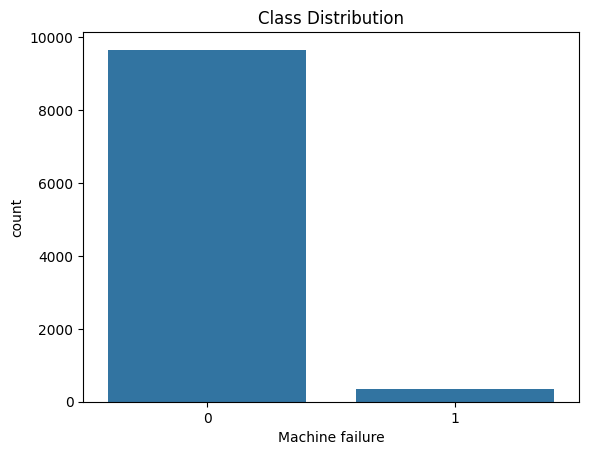

In [ ]:
print("Shape:", df.shape)
print("\nClass Distribution:\n", df["Machine failure"].value_counts())

sns.countplot(x="Machine failure", data=df)
plt.title("Class Distribution")
plt.show()

# **Encode Categorical Features (One-Hot Encoding)**

In [ ]:
df = pd.get_dummies(df, columns=["Type"], drop_first=True)

# **Split Data into Features and Target + Train-Test Split**

In [ ]:
X = df.drop("Machine failure", axis=1)
y = df["Machine failure"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# **Handle Class Imbalance Using SMOTE**

In [ ]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# **Train Random Forest Classification Model**

In [ ]:
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42
)

model.fit(X_train_bal, y_train_bal)

RandomForestClassifier(n_estimators=300, random_state=42)

# **Evaluate Model Performance (Confusion Matrix & Metrics)**

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[1877   55]
 [  19   49]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1932
           1       0.47      0.72      0.57        68

    accuracy                           0.96      2000
   macro avg       0.73      0.85      0.78      2000
weighted avg       0.97      0.96      0.97      2000


ROC-AUC Score: 0.9578804347826086


# **Plot ROC Curve**

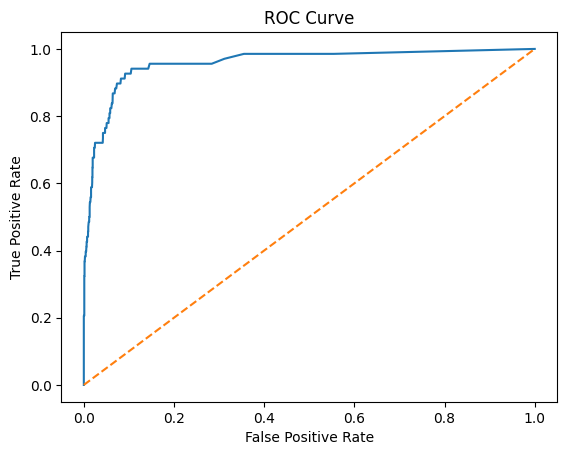

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# **Perform Cross-Validation**

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model,
    X_train_bal,
    y_train_bal,
    cv=cv,
    scoring="roc_auc"
)

print("Cross Validation ROC-AUC:", cv_scores.mean())

Cross Validation ROC-AUC: 0.9982750715742975


# **Analyze Feature Importance**

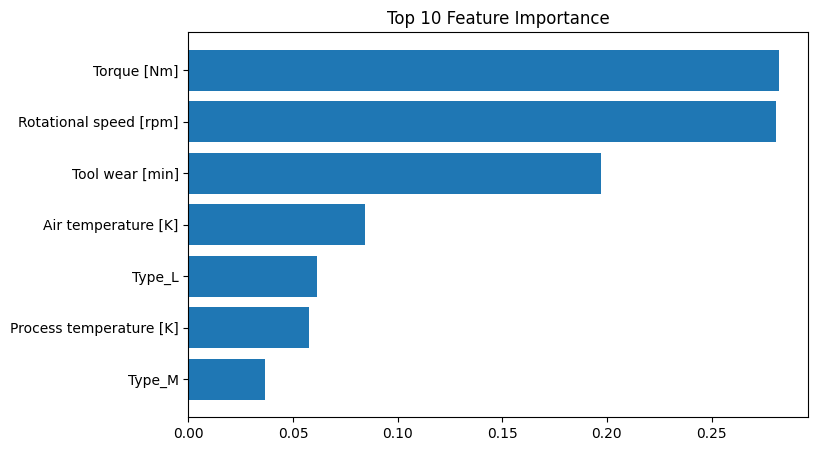

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), X.columns[indices])
plt.title("Top 10 Feature Importance")
plt.show()

# **Model Explainability Using SHAP**

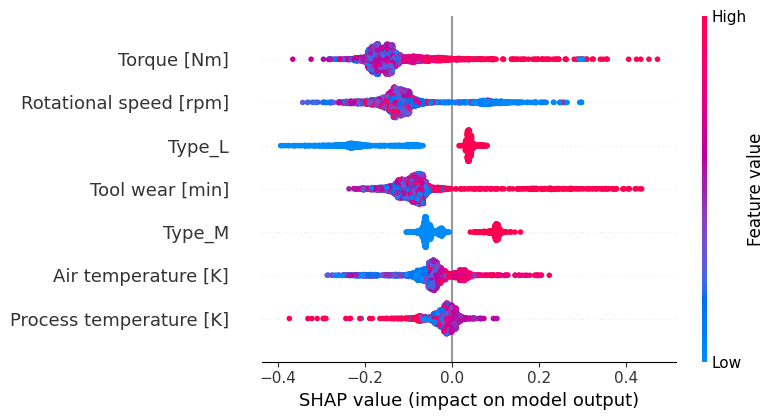

In [ ]:
!pip install shap

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test)

# **Save Trained Model**

In [ ]:
joblib.dump(model, "model.pkl")

['model.pkl']

# **Load Saved Model**

In [ ]:
loaded_model = joblib.load("model.pkl")

# **Generate Predictions on Test Data**

In [ ]:
y_pred = loaded_model.predict(X_test)
y_prob = loaded_model.predict_proba(X_test)[:,1]

results = X_test.copy()
results["Actual"] = y_test.values
results["Predicted"] = y_pred
results["Failure_Probability"] = y_prob

results.head(100)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_L,Type_M,Actual,Predicted,Failure_Probability
2997,300.5,309.8,1345,62.7,153,True,False,0,1,0.740000
4871,303.7,312.4,1513,40.1,135,True,False,0,0,0.000000
3858,302.5,311.4,1559,37.6,209,True,False,0,0,0.433333
951,295.6,306.3,1509,35.8,60,False,False,0,0,0.003333
6463,300.5,310.0,1358,60.4,102,False,False,0,0,0.173333
...,...,...,...,...,...,...,...,...,...,...
4111,302.0,310.6,1563,41.0,184,False,True,0,0,0.003333
4231,302.2,310.8,1340,47.8,54,True,False,0,1,0.890000
7884,300.8,312.4,1465,59.1,91,True,False,1,0,0.310000
871,295.8,306.4,1339,53.2,67,True,False,0,0,0.006667


# **View Failed Machine Predictions**

In [ ]:
results[results["Predicted"] == 1].head(10)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_L,Type_M,Actual,Predicted,Failure_Probability
2997,300.5,309.8,1345,62.7,153,True,False,0,1,0.740000
1391,298.9,310.2,2737,8.8,142,True,False,1,1,0.996667
3104,299.8,309.2,1678,29.8,202,False,True,0,1,0.523333
4495,302.6,310.4,1359,57.2,67,True,False,1,1,0.970000
8582,297.5,308.1,1334,72.0,151,False,True,1,1,0.686667
9664,299.1,310.2,1317,54.8,231,True,False,1,1,0.926667
5821,301.3,311.1,1303,49.2,212,True,False,0,1,0.776667
3026,300.4,309.5,1888,21.9,221,False,True,0,1,0.816667
4231,302.2,310.8,1340,47.8,54,True,False,0,1,0.890000
4381,301.9,309.6,1446,43.2,225,True,False,0,1,0.836667


# **Test Model on a Single Sample**

In [ ]:
sample = X_test.iloc[0:1]

prediction = loaded_model.predict(sample)
probability = loaded_model.predict_proba(sample)[:,1]

print("Prediction:", prediction[0])
print("Failure Probability:", probability[0])

Prediction: 1
Failure Probability: 0.74
